In [1]:
from platform import python_version

print(python_version())


3.8.5


In [2]:
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
from scipy import constants

#Marius:
from tqdm import tqdm
import numba

In [3]:
#Global variables
L = 10 #unit:nm length of the box
N = 50#100 #unit:numbers
m = 39.948 # unit: a.m.u
T = 100 #unit:kelvin
KB = constants.R*10**-3  #unit KJ/mol.K
dt = 10**-3 #unit:ps
n_steps =10000 #unitness
epsilon = 1
sigma = 0.34
tauT = 0.1 #Coupling constant for the Berendsen thermostat #ps, tau referenced online for 0.1-0.4 ps for dt of 1fs(femtosecond)
tauP = 5 #Pressure coupling constant for Berendsen Barostat


In [4]:
def write_file(FILE1, coords, n_iter):

    '''

    This function is used to save obtained coordinates into the PyMol readable format PDB.
    It also writes several other interesting stuff to plain .txt files.

    FILE1 := Coordinaten File Name (Should end with .pdb)
    n_iter := Number of step

    '''


    #Coordinates are round to the second decimal position to faciliate saving
    round_ = 2

    #Write head for each frame
    FILE1.write('MODEL {}\n'.format(n_iter)) #Start of a frame
    N = coords.shape[0] #Get number of atoms


    #Just iterate over all coordinates and write them down line per line
    for i in range(N):

        #The PDB-formate is really strict the line below is from: https://cupnet.net/pdb-format/

        #ATOM  #ID   #NAME     #RESN      #RESID          #X    #Y     #Z
        coord_str = "{:6s}{:5d} {:^4s}{:1s}{:3s} {:1s}{:4d}{:1s}   {:8.3f}{:8.3f}{:8.3f}{:6.2f}{:6.2f}          {:>2s}{:2s}\n".format('ATOM', int(i),
                                                                                                                         'PAR', ' ', 'ARG',
                                                                                                                         ' ', int(i), ' ',
                                                                                                                         np.round(coords[i][0], round_)*10,
                                                                                                                         np.round(coords[i][1], round_)*10,
                                                                                                                         np.round(coords[i][2], round_)*10,
                                                                                                                          1.0, 1.0, 'Ar', ' ')


        FILE1.write(coord_str) #Write coordinates
    FILE1.write('TER\nENDMDL\n') #End of a frame


## Initialize positions/velocities

In [5]:
def init_pos():
    """initialize position of atoms within L in x, y, z coordinates where L = 2
    Border and grid set to be "smaller" than the box size where L = 2 """
    coord =[]
    border= 2*sigma # no atoms will generate that are <2*sigma
    Grid = (L-border) # no atoms will generate that are > L-(2*sigma)

    #Here the problem was that you could have the same positions. We fixed that with an if-statement and a while loop.

    while len(coord) < N:

        coordinates = [np.random.choice(np.arange(border,Grid,0.1)), np.random.choice(np.arange(border,Grid,0.1)), np.random.choice(np.arange(border,Grid,0.1))]

        if not coordinates in coord: coord.append(coordinates)

    return np.array(coord)


In [6]:
def init_vel():
    """initialize random velocities of the atoms"""
    velocity = np.random.normal(0, np.sqrt(KB*T/m),(N,3)) #Cleaned up some variable names!
    #print(temp(velocity))

    return velocity

In [7]:
def hist_plot(file_name, vels):
    fig, ax = plt.subplots(2,2)
    y_axes = ['Freq', 'Freq', 'Freq', 'Prob density']
    x_axes = ['Vx', 'Vy', 'Vz', 'V']
    title =['Hist Vx', 'Hist Vy', 'Hist Vz', 'Maxwell boltzman distribution']
    c=0
    for i in range(2):
        for j in range(2):
            if c !=3:

                ax[i,j].hist(vels[:,c], bins =20, density=True)
                ax[i,j].set_title(title[c])
                ax[i,j].set_xlabel(x_axes[c])
                ax[i,j].set_ylabel(y_axes[c])
            else:
                ax[i,j].hist(np.sqrt(np.sum(vel**2, 1)), bins =20, density=True)
                ax[i,j].set_title(title[c])
                ax[i,j].set_xlabel(x_axes[c])
                ax[i,j].set_ylabel(y_axes[c])

            c+=1
    plt.tight_layout()


# Test atoms for algorithms

In [8]:
def test_pos():
    """For testing of the different boundaries"""
    pos = np.array([[1,5,5], [0.5,5,5]])

    return pos

In [9]:
def test_vel():
    """For testing of the different boundaries"""
    vel = np.array([[0,0,0], [0,0,0]])

    return vel

# Defining Boundaries and initialization of force

In [10]:
def no_bounds(pos, vel):
    """BOUNDARY CONDITION for wall potential"""
    return pos, vel

In [11]:
#def compute_force(pos): # initialised to zero at the beginning of the simulation-- will increase later
#    """set forces to 0"""
#    pos = np.zeros((N,3))
#    return np.zeros(pos.shape)

#-> Test case for non-interacting particles! We don't need anymore


In [12]:
def pbc(pos, vel, L):
    pos = np.where(pos>0, pos ,L+pos) #for all positions of atoms bigger than 0, stay as it is. otherwise plus L to be in the box
    pos = np.where(pos<L, pos, pos-L) #for all positions of atoms smaller than L, stay as it is. otherwise minus L to be in the box


    #helps to prevent atoms from flying away
    mean =np.zeros(3)
    counter =0
    for vec in vel:
        mean +=vec
        counter +=1
    mean /= counter
    vel -=mean

    return pos, vel


In [13]:
def Angle(pos, vel):
    """Boundary where particles bounces off the wall at an angle"""
    for i in range(N):
        for j in range(3):
            if pos[i,j]<0:
                pos[i,j] = pos[i,j]*(-1) #When particles in x, y, z coodrinates outside of the "box", pos<0. angle reflection has to be same
                vel[i,j]=  vel[i,j]*(-1)

            elif pos[i,j]>L:
                pos[i,j] = 2*L-pos[i,j] #When particles in x, y, z coodrinates outside of the "box", pos>L. angle reflection has to be same
                vel[i,j]=  vel[i,j]*(-1)

    return pos, vel

In [14]:
def wall_force(pos):
    """Wall potential repulsion (F) according to lennard jones potential, only the repulsion part of the equation is taken into account"""

    force = np.zeros((N,3))
    for i in range(N):
        for j in range(3):
            if pos[i,j]<(4*sigma):
                force[i,j] = 48*(epsilon/sigma)*((sigma/(np.absolute(pos[i,j]))**13))



            elif pos[i,j]>(L-(4*sigma)):
                force[i,j] = -48*(epsilon/sigma)*((sigma/(L-pos[i,j]))**13) #- sign, because the force needs to be in the negative direction as it repels from the right side of the box


    return force

# Temperature and pressure coupling

In [15]:
def temp(vel):
    """Returns the current temperature of the system"""
    #KE = e_kin(vel)
    #temp = 2*KE*N/3*KB -> We changed it to below line
    #init_temp = 200
    temp = (m * np.sum(vel**2)) / (3 * N * KB)
    #curr_temp = init_temp + temp

    return temp
    #return curr_temp


In [16]:
def berendsen_temp(vel):
    """Berendsen thermostat"""

    temp_new = temp(vel)
    scale = np.sqrt(1+(dt/tauT)*(T/temp_new-1))
    
    return scale

In [17]:
def pressure_coupling(P): #pressure calculation see the Interacting_atoms function
    """Berendsen Barostat"""
    B= 1.8*(10**-4)
    P0 = 1
    scale_P = (1 +(dt / tauP) * B * (P0 - P))**(1/3)
    #scale_P = (1 - 1/ KB* dt / tauP * (P0 - P) )**(1/3)

    return scale_P

In [124]:
tauP

5

# Algorithms

In [18]:
def Euler(pos, vel, boundary):
    """Euler algorithm, kraft frei"""
    pos_new = pos+ vel*dt
    pos_new, vel_new =boundary(pos_new, vel)       
        
    
    
    return pos_new

In [19]:
def Verlet(pos, pos_old, vel, force, boundary):
    """Verlet algorithm"""
    force = Interacting_atoms(pos) 
    #force = force + wall_force(pos) #+In order to implement wall potential
    pos_new = 2*pos - pos_old + force/m * dt**2
    vel = ((pos_new  - pos_old)/2*dt)
    pos_new, vel_new =boundary(pos_new, vel)
    
    return pos_new, pos, vel_new

In [38]:
def Velocity_verlet(pos, vel, boundary, L):
    """Velocity Verlet to run with Wall boundary repulsion according to lennard jones potential.
    Only repulsion is taken into account. Interaction of atoms according to LJ included"""
    #force = compute_force(pos) + wall_force(pos) #when computing forces
    force, P, vol = Interacting_atoms(pos, L, NL)

    scale = berendsen_temp(vel) ##Scale value for berendsen thermostat
    
    scale_P =pressure_coupling(P)#Scale value for berendsen barostat
    
    #Scaling of temperature coupling
    vel = scale*vel
    
    
    pos_new = pos + vel*dt + (force/(2*m))*dt**2  # Veleocity verlet algorithm for position
    #force_new = compute_force(pos_new) + wall_force(pos_new)
    force_new, P, vol = Interacting_atoms(pos_new, L, NL)

    #Scaling of box size and new positions
    pos_new= scale_P*pos_new
    L=scale_P*L

    vel_new = vel + ((force_new + force)/(2*m))*dt # Veleocity verlet algorithm for velocity



    pos_new, vel_new =boundary(pos_new, vel_new, L)

    return pos_new, vel_new, P, vol


In [71]:
def Leapfrog(pos, vel, boundary, L, NL):
    """Leapfrog algorithm"""
    force, P, vol = Interacting_atoms(pos, L, NL) #when computing forces, this will not be correct
    #force = compute_force(pos) + wall_force(pos) # in order to implement wall_force repulsion



    #1) Generate new velocities based on old (correct) velocities
    vel_new = vel + dt*(force/m)

    #2) Calculate scaling factor for new (uncorrected) velocities
    scale = berendsen_temp(vel_new) #Scale value for berendsen thermostat
    scale_P =pressure_coupling(P)
    
    
    #pos = scale_P * pos

    #3) Apply scaling to new velocities
    vel_new = scale*vel_new #scale value taken into account for new velocities

    #4) Make new positions
    pos_new = pos + dt*vel_new
    
    #Scale box size and new positions
    pos_new = scale_P * pos_new
    
    L=scale_P*L
    
    pos_new, vel_new = boundary(pos_new, vel_new, L)


    print(force)
    #print(scale_P, P)

    return pos_new, vel_new, P, L, vol


In [22]:
@numba.jit(nopython = True, fastmath = True)
def get_positions(pos1, pos2):
    """Return der direction of r and the absolute value of r (Distance)"""

    r_vector = (pos1 - pos2) # positions in x,y,z coordinates

    if r_vector[0] > L/2:
        r_vector[0] = r_vector[0] -L
    elif r_vector[0] < -L/2:
        r_vector[0] = L + r_vector[0]

    if r_vector[1] > L/2:
        r_vector[1] = r_vector[1] -L
    elif r_vector[1] < -L/2:
        r_vector[1] = L + r_vector[1]

    if r_vector[2] > L/2:
        r_vector[2] = r_vector[2] -L
    elif r_vector[2] < -L/2:
        r_vector[2] = L + r_vector[2]


    absolute_r = (np.sqrt(r_vector[0]**2 + r_vector[1]**2 +r_vector[2]**2)) #obtain the absolute positions of r

    return r_vector, absolute_r


In [23]:
def e_kin(vel):
    """Return the kinetic enery of the system"""
    #vel = init_vel(1000) -> NO!
    KE = np.sum(1/2*m*vel**2)

    return KE



In [24]:
def e_pot(pos):
    """Function that calculate the potential energy according to LJ potential"""
    PE =0
    for i in range(N):
        for j in range(N):

            if i <= j:
                continue

            else:
                r_vector, absolute_r = get_positions(pos[i],pos[j])

                PE = PE + 4*epsilon*((sigma/absolute_r)**12 - (sigma/absolute_r)**6)

    return PE

In [25]:
def total_energy(pos, vel):
    """Total energy of the system from KE and PE"""

    TE = e_kin(vel) + e_pot(pos) #Removed np.sum -> Redundant


    return TE

In [26]:
def Interacting_atoms(pos, L, NL):
    """function that describes interaction between atoms according to LJ potential (Force)"""


    #Think about the for-loop -> Can you skip half of the calculations?
    #Hint: Your potential energy function

    Rc_force = 1 #nm
    force = np.zeros((N,3))
    dV_sum = 0

    P=0
    for i in range(N): # Loop over all atoms
        for j in range(N): #Loop over all other atoms (interacting atoms)
            if i == j: #Skip self forces
                continue
            else: #sum of all forces where i != to J


                r_vector, absolute_r = get_positions(pos[i],pos[j]) #calling the get_positions function to calculate force between two atoms (i and j) index representing each atom in i and each atom in



                if absolute_r <= Rc_force: #only calculate the forces of atoms in the Rc_force zone

                    dV = 24*(epsilon/sigma)*(2*((sigma/(absolute_r))**13)-(sigma/(absolute_r))**7)

                    for k in range(3):



                        force[i,k] += dV*(r_vector[k]/absolute_r)#compute force to each particle

                    dV_sum += dV * r_vector[k]
                    #print(dV_sum)

    #Pressure calculation


    vol = L**3

    P += (1/vol)*(N*KB*T-1/3*(dV_sum))/6.022*100 # prefactor of avogrado constant multplied by 100, converts units to bar
    


                #Force_vector = negative derivative of potential * r_vector/absolute value of r, where r = distance between two atoms


    return force, P, vol


In [27]:
@numba.jit(nopython = True, fastmath = True)
def Neighbor_list(pos):
    """omits atoms in the simulation when they are too far away
    to save computing time. Atoms that too far away are determined by
    the cut off value."""
    Rc = 1.2  #Cut off value radius of i, buffer zone
    neighbors=[]
    for i in range(N):
        list_2 =[]
        for j in range(N):
            if i==j: #Skip self forces
                continue


            else:
                r_vector, absolute_r = get_positions(pos[i],pos[j])

                if absolute_r < Rc:
                    list_2.append(j)

        neighbors.append(list_2.copy())

    return neighbors

In [40]:
def main(mode, L):
    pos=init_pos()
    vel=init_vel()
    #pos=test_pos()
    #vel=test_vel()

    file_name=open("read.pdb", "w")
    file_name.write('CRYST1'+str("{0:9.3f}{0:9.3f}{0:9.3f}").format(L*10,L*10,L*10)+'  90.00  90.00  90.00 P 1           1\n')
    write_file(file_name, pos, 0)

    if mode == 0:
        """Run euler algorithm"""
        for n_iter in range(n_steps):
            pos=Euler(pos, vel, pbc)
            if n_iter%50 ==0:
                write_file(file_name, pos, n_iter)
            KE = e_kin(vel)


    if mode == 1:
        """Run verlet algorithm"""
        dist_atoms = []
        PE =[]
        KE =[]
        TE =[]
        pos_old = pos
        pos = Euler(pos, vel, pbc)
        for n_iter in tqdm(range(n_steps)):
            force=Interacting_atoms(pos)
            #force=compute_force(pos)
            #force+=wall_force(pos)
            pos, pos_old, vel=Verlet(pos, pos_old, vel, force, pbc)
            #pos, pos_old=Verlet(pos, pos_old, vel, force, no_bounds)
            if n_iter%50 ==0:
                NL = Neighbor_list(pos)
                write_file(file_name, pos, n_iter)

            dist_atoms.append(get_positions(pos[0], pos[1])[1])
            PE.append(e_pot(pos))
            KE.append(e_kin(vel))
            TE.append(total_energy(pos, vel))



    if mode == 2:
        """Run verlocity verlet algorithm"""
        dist_atoms = []
        PE =[]
        KE =[]
        TE =[]
        Temp =[]
        Pressure =[]
        Volume=[]
        for n_iter in tqdm(range(n_steps)):
            pos, vel, P, vol= Velocity_verlet(pos, vel, pbc, L)
            #pos, vel = Velocity_verlet(pos, vel, no_bounds) #no_bounds to implement wall_force boundary.
            if n_iter%1 ==0:
                NL = Neighbor_list(pos)
                write_file(file_name, pos, n_iter)


            dist_atoms.append(get_positions(pos[0], pos[1])[1])
            PE.append(e_pot(pos))
            KE.append(e_kin(vel))
            TE.append(total_energy(pos, vel))
            Temp.append(temp(vel))
            Pressure.append(P)
            Volume.append(vol)


    if mode == 3:
        """Run leapfrog algorithm"""
        dist_atoms = []
        PE =[]
        KE =[]
        TE =[]
        Temp =[]
        Pressure =[]
        Volume=[]
        NL = Neighbor_list(pos) # initial list
        for n_iter in tqdm(range(n_steps)):
            pos, vel, P, L, vol= Leapfrog(pos, vel, pbc, L, NL)
            #pos, vel = Leapfrog(pos, vel, no_bounds) #to implement wall_force boundary
            if n_iter%10 ==0:
                NL = Neighbor_list(pos)#Updated p list
                write_file(file_name, pos, n_iter)



            dist_atoms.append(get_positions(pos[0], pos[1])[1])
            PE.append(e_pot(pos))
            KE.append(e_kin(vel))
            TE.append(total_energy(pos, vel))
            Temp.append(temp(vel))
            Pressure.append(P)
            Volume.append(vol)







    file_name.close()
    return dist_atoms, PE, KE, TE, NL, Temp, Pressure, Volume

# VV N=100

In [72]:
N=100
dist_atoms, PE, KE, TE, NL, Tem, Pres, vol= main(2, L)

  1%|          | 120/10000 [00:05<07:53, 20.88it/s]


KeyboardInterrupt: 

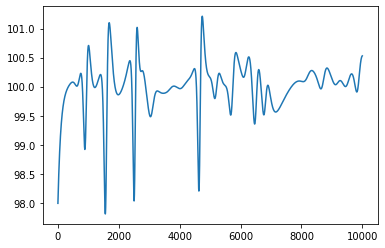

In [66]:
plt.plot(Tem)

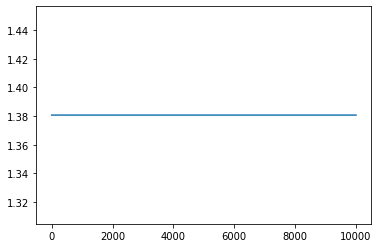

In [70]:
plt.plot(Pres)

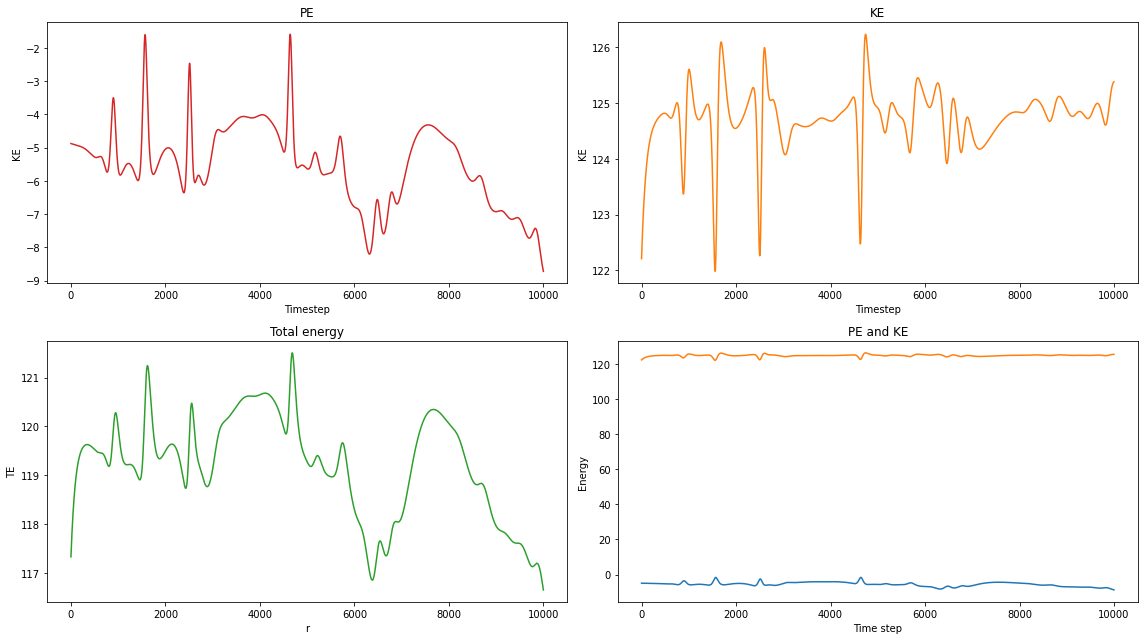

In [67]:
fig, axs = plt.subplots(2, 2, figsize=(16,9))

axs[0, 0].plot(PE, 'tab:red')
axs[0, 0].set_title('PE')
axs[0, 0].set_xlabel('Timestep')
axs[0, 0].set_ylabel('KE')

axs[0, 1].plot(KE, 'tab:orange')
axs[0, 1].set_title('KE')
axs[0, 1].set_xlabel('Timestep')
axs[0, 1].set_ylabel('KE')

axs[1, 0].plot(TE, 'tab:green') # spikes in the total energy at 10^-3 timestep 
axs[1, 0].set_title('Total energy')
axs[1, 0].set_xlabel('r')
axs[1, 0].set_ylabel('TE')

axs[1, 1].plot(PE,'tab:blue')
axs[1, 1].plot(KE, 'tab:orange')
axs[1, 1].set_title('PE and KE')
axs[1, 1].set_xlabel('Time step')
axs[1, 1].set_ylabel('Energy')

plt.tight_layout()

## LF N=200

In [73]:
N=200
dist_atoms, PE, KE, TE, NL, Tem, Pres, vol= main(3, L)

  0%|          | 2/10000 [00:00<19:22,  8.60it/s]

[[ 3.68178356e+02  1.84418788e+02 -3.62103591e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.27467415e-01  5.46288923e-02 -5.46288923e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 7.66892989e-01  0.00000000e+00 -1.27815498e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.94671249e-02  0.00000000e+00 -4.24003928e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.64288694e-01 -2.05360867e-02  0.00000000e+00]
 [-3.68090981e-02 -9.81575950e-02  1.22696994e-02]
 [ 7.34773605e-02  3.78700595e-02 -9.79836569e-03]
 [-6.58995020e+00  1.64748755e+00  0.00000000e+00]
 [-7.70646085e-02  0.00000000e+00  0.00000000e+00]
 [-2.15298104e-01  1.28240422e-01  1.69423161e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.22696994e-02 -3.68090981e-02 -9.81575950e-02]
 [ 1.27815498e+00  0.00000000e+

  0%|          | 4/10000 [00:00<19:36,  8.49it/s]

[[ 3.76263403e+02  1.88456906e+02 -3.70689001e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.28012428e-01  5.49465053e-02 -5.48651199e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 7.70030983e-01  4.96169768e-04 -1.28301555e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.96048792e-02  9.51772508e-06 -4.24381490e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.63439004e-01 -2.04050212e-02 -9.00468756e-05]
 [-3.68662012e-02 -9.82972489e-02  1.22708447e-02]
 [ 7.35261890e-02  3.87218969e-02 -1.14424979e-02]
 [-6.62314407e+00  1.65066318e+00  2.89843255e-03]
 [-7.67258617e-02 -3.03696344e-05  2.28887435e-05]
 [-2.17094615e-01  1.29151628e-01  1.70475801e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.22449706e-02 -3.67799500e-02 -9.78111494e-02]
 [ 1.27256142e+00 -2.80210922e-

  0%|          | 7/10000 [00:00<19:23,  8.59it/s]

[[ 3.84668451e+02  1.92650769e+02 -3.79873023e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.28833620e-01  5.54259924e-02 -5.52210829e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 7.74762721e-01  1.24801965e-03 -1.29034199e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.98114007e-02  2.38606172e-05 -4.24941296e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.62174382e-01 -2.02102508e-02 -2.22984466e-04]
 [-3.69519556e-02 -9.85069377e-02  1.22725138e-02]
 [ 7.36079694e-02  3.99899132e-02 -1.38833194e-02]
 [-6.66804614e+00  1.65415948e+00  7.27152161e-03]
 [-7.62222948e-02 -7.53159263e-05  5.70040784e-05]
 [-2.19799877e-01  1.30527108e-01  1.72063960e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.22078407e-02 -3.67354302e-02 -9.72934060e-02]
 [ 1.26423590e+00 -6.94843743e-

  0%|          | 9/10000 [00:01<20:04,  8.30it/s]

[[ 3.87603420e+02  1.94111374e+02 -3.83333270e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.29382909e-01  5.57473379e-02 -5.54592035e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 7.77930182e-01  1.75377404e-03 -1.29524453e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.99488482e-02  3.34555715e-05 -4.25309711e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.61338808e-01 -2.00817568e-02 -3.10107199e-04]
 [-3.70091263e-02 -9.86467091e-02  1.22735927e-02]
 [ 7.36680590e-02  4.08278583e-02 -1.54920333e-02]
 [-6.69483662e+00  1.65568880e+00  1.01956832e-02]
 [-7.58899443e-02 -1.04846856e-04  7.95744915e-05]
 [-2.21608408e-01  1.31448871e-01  1.73127697e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.21830925e-02 -3.67052597e-02 -9.69499189e-02]
 [ 1.25873463e+00 -9.67214315e-

  0%|          | 10/10000 [00:01<21:43,  7.66it/s]

[[ 3.88319744e+02  1.94462010e+02 -3.84568753e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.29933216e-01  5.60697756e-02 -5.56977808e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 7.81105491e-01  2.26275048e-03 -1.30015775e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.00859959e-02  4.30689105e-05 -4.25674005e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.60509847e-01 -1.99544353e-02 -3.95977304e-04]
 [-3.70662517e-02 -9.87863508e-02  1.22746438e-02]
 [ 7.37324957e-02  4.16592700e-02 -1.70849040e-02]
 [-6.71921124e+00  1.65661234e+00  1.31208618e-02]
 [-7.55604992e-02 -1.34013268e-04  1.01987183e-04]
 [-2.23419550e-01  1.32373734e-01  1.74194567e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.21583692e-02 -3.66747278e-02 -9.66080442e-02]
 [ 1.25327663e+00 -1.23617478e-

  0%|          | 13/10000 [00:01<20:30,  8.12it/s]

[[ 3.86805553e+02  1.93696962e+02 -3.83558380e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.30484264e-01  5.63931455e-02 -5.59366954e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 7.84287092e-01  2.77470219e-03 -1.30507925e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.02227749e-02  5.26955962e-05 -4.26034013e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.59687837e-01 -1.98283349e-02 -4.80571469e-04]
 [-3.71233036e-02 -9.89257938e-02  1.22756666e-02]
 [ 7.38011877e-02  4.24838040e-02 -1.86613924e-02]
 [-6.74126221e+00  1.65696083e+00  1.60427276e-02]
 [-7.52340735e-02 -1.62806483e-04  1.24230718e-04]
 [-2.25232449e-01  1.33301254e-01  1.75264053e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.21336839e-02 -3.66438564e-02 -9.62679428e-02]
 [ 1.24786412e+00 -1.50164224e-

  0%|          | 15/10000 [00:01<19:32,  8.51it/s]

[[ 3.83101995e+02  1.91837027e+02 -3.80334580e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.31035865e-01  5.67173369e-02 -5.61758652e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 7.87473926e-01  3.28945837e-03 -1.31000737e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.03591389e-02  6.23320950e-05 -4.26389634e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.58872977e-01 -1.97034825e-02 -5.63881676e-04]
 [-3.71802630e-02 -9.90649919e-02  1.22766611e-02]
 [ 7.38740477e-02  4.33012579e-02 -2.02212327e-02]
 [-6.76108497e+00  1.65676458e+00  1.89576274e-02]
 [-7.49107257e-02 -1.91222903e-04  1.46297568e-04]
 [-2.27046534e-01  1.34231129e-01  1.76335805e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.21090455e-02 -3.66126625e-02 -9.59297189e-02]
 [ 1.24249839e+00 -1.76358107e-

  0%|          | 17/10000 [00:02<20:46,  8.01it/s]

[[ 3.77300223e+02  1.88927998e+02 -3.74980622e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.31587894e-01  5.70422767e-02 -5.64152362e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 7.90665304e-01  3.80690573e-03 -1.31494107e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.04950577e-02  7.19760011e-05 -4.26740816e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.58065360e-01 -1.95798892e-02 -6.45910856e-04]
 [-3.72371177e-02 -9.92039155e-02  1.22776272e-02]
 [ 7.39509931e-02  4.41115325e-02 -2.17643568e-02]
 [-6.77877557e+00  1.65605309e+00  2.18624603e-02]
 [-7.45904738e-02 -2.19262585e-04  1.68183053e-04]
 [-2.28861445e-01  1.35163166e-01  1.77409594e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.20844601e-02 -3.65811602e-02 -9.55934345e-02]
 [ 1.23718007e+00 -2.02198972e-

  0%|          | 19/10000 [00:02<21:37,  7.70it/s]

[[ 3.69536311e+02  1.85038114e+02 -3.67625787e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.32140270e-01  5.73679178e-02 -5.66547736e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 7.93860798e-01  4.32697147e-03 -1.31987968e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.06305132e-02  8.16256978e-05 -4.27087537e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.57265011e-01 -1.94575550e-02 -7.26669244e-04]
 [-3.72938603e-02 -9.93425464e-02  1.22785649e-02]
 [ 7.40319456e-02  4.49145998e-02 -2.32908303e-02]
 [-6.79442882e+00  1.65485475e+00  2.47545632e-02]
 [-7.42733087e-02 -2.46928025e-04  1.89884447e-04]
 [-2.30676971e-01  1.36097244e-01  1.78485280e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.20599315e-02 -3.65493608e-02 -9.52591225e-02]
 [ 1.23190933e+00 -2.27688947e-

  0%|          | 20/10000 [00:02<22:26,  7.41it/s]

[[ 3.59984438e+02  1.80254647e+02 -3.58438755e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.32692945e-01  5.76942309e-02 -5.68944561e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 7.97060156e-01  4.84961061e-03 -1.32482281e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.07654946e-02  9.12801065e-05 -4.27429797e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.56471906e-01 -1.93364730e-02 -8.06171751e-04]
 [-3.73504866e-02 -9.94808746e-02  1.22794745e-02]
 [ 7.41168308e-02  4.57104782e-02 -2.48008053e-02]
 [-6.80813719e+00  1.65319679e+00  2.76316220e-02]
 [-7.39592029e-02 -2.74223284e-04  2.11400317e-04]
 [-2.32493002e-01  1.37033294e-01  1.79562780e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.20354623e-02 -3.65172738e-02 -9.49267966e-02]
 [ 1.22668600e+00 -2.52831638e-

  0%|          | 23/10000 [00:02<23:26,  7.09it/s]

[[ 3.48848780e+02  1.74679840e+02 -3.47619631e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.33245890e-01  5.80211988e-02 -5.71342713e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.00263246e-01  5.37479709e-03 -1.32977027e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.08999966e-02  1.00938511e-04 -4.27767611e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.55685991e-01 -1.92166315e-02 -8.84436187e-04]
 [-3.74069944e-02 -9.96188951e-02  1.22803561e-02]
 [ 7.42055775e-02  4.64992166e-02 -2.62944890e-02]
 [-6.81999013e+00  1.65110515e+00  3.04916056e-02]
 [-7.36481180e-02 -3.01153395e-04  2.32730077e-04]
 [-2.34309491e-01  1.37971283e-01  1.80642052e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.20110541e-02 -3.64849078e-02 -9.45964574e-02]
 [ 1.22150976e+00 -2.77631577e-

  0%|          | 25/10000 [00:03<21:40,  7.67it/s]

[[ 3.36354684e+02  1.68426492e+02 -3.35391159e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.33799090e-01  5.83488123e-02 -5.73742128e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.03470017e-01  5.90251766e-03 -1.33472197e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.10340172e-02  1.10600441e-04 -4.28101001e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.54907195e-01 -1.90980162e-02 -9.61482078e-04]
 [-3.74633832e-02 -9.97566065e-02  1.22812100e-02]
 [ 7.42981174e-02  4.72808835e-02 -2.77721224e-02]
 [-6.83007381e+00  1.64860454e+00  3.33327179e-02]
 [-7.33400080e-02 -3.27723971e-04  2.53873684e-04]
 [-2.36126441e-01  1.38911199e-01  1.81723080e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.19867077e-02 -3.64522701e-02 -9.42680970e-02]
 [ 1.21638012e+00 -3.02093858e-

  0%|          | 27/10000 [00:03<20:55,  7.95it/s]

[[ 3.22739667e+02  1.61613455e+02 -3.21989702e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.34352540e-01  5.86770678e-02 -5.76142782e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.06680469e-01  6.43276784e-03 -1.33967793e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.11675568e-02  1.20265588e-04 -4.28429996e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.54135432e-01 -1.89806107e-02 -1.03732990e-03]
 [-3.75196532e-02 -9.98940098e-02  1.22820363e-02]
 [ 7.43943846e-02  4.80555594e-02 -2.92339659e-02]
 [-6.83847088e+00  1.64571846e+00  3.61533627e-02]
 [-7.30348230e-02 -3.53940942e-04  2.74831447e-04]
 [-2.37943881e-01  1.39853046e-01  1.82805865e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.19624237e-02 -3.64193677e-02 -9.39417023e-02]
 [ 1.21129653e+00 -3.26223896e-

  0%|          | 28/10000 [00:03<20:45,  8.01it/s]

[[ 3.08244800e+02  1.54361325e+02 -3.07656532e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.34906240e-01  5.90059651e-02 -5.78544678e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.09894640e-01  6.96554918e-03 -1.34463819e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.13006171e-02  1.29933757e-04 -4.28754629e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.53370611e-01 -1.88643979e-02 -1.11200057e-03]
 [-3.75758054e-02 -1.00031107e-01  1.22828352e-02]
 [ 7.44943154e-02  4.88233321e-02 -3.06802910e-02]
 [-6.84526055e+00  1.64246922e+00  3.89521168e-02]
 [-7.27325107e-02 -3.79810392e-04  2.95603888e-04]
 [-2.39761860e-01  1.40796839e-01  1.83890422e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.19382023e-02 -3.63862068e-02 -9.36172563e-02]
 [ 1.20625840e+00 -3.50027272e-

  0%|          | 30/10000 [00:03<22:34,  7.36it/s]

[[ 2.93106908e+02  1.46788545e+02 -2.92629886e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.35460196e-01  5.93355070e-02 -5.80947837e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.13112593e-01  7.50086744e-03 -1.34960288e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.14332011e-02  1.39604830e-04 -4.29074933e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.52612635e-01 -1.87493598e-02 -1.18551514e-03]
 [-3.76318412e-02 -1.00167902e-01  1.22836071e-02]
 [ 7.45978483e-02  4.95842937e-02 -3.21113734e-02]
 [-6.85051859e+00  1.63887801e+00  4.17277097e-02]
 [-7.24330176e-02 -4.05338447e-04  3.16191666e-04]
 [-2.41580442e-01  1.41742599e-01  1.84976772e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.19140436e-02 -3.63527934e-02 -9.32947400e-02]
 [ 1.20126509e+00 -3.73509634e-

  0%|          | 33/10000 [00:04<22:20,  7.44it/s]

[[ 2.77551933e+02  1.39008091e+02 -2.77138151e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.36014415e-01  5.96656975e-02 -5.83352294e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.16334408e-01  8.03873131e-03 -1.35457210e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.15653123e-02  1.49278741e-04 -4.29390945e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.51861406e-01 -1.86354783e-02 -1.25789455e-03]
 [-3.76877621e-02 -1.00304399e-01  1.22843522e-02]
 [ 7.47049234e-02  5.03385385e-02 -3.35274899e-02]
 [-6.85431743e+00  1.63496494e+00  4.44790068e-02]
 [-7.21362900e-02 -4.30531207e-04  3.36595514e-04]
 [-2.43399698e-01  1.42690353e-01  1.86064944e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.18899474e-02 -3.63191332e-02 -9.29741326e-02]
 [ 1.19631596e+00 -3.96676622e-

  0%|          | 35/10000 [00:04<22:12,  7.48it/s]

[[ 2.61789641e+02  1.31124822e+02 -2.61394359e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.36568907e-01  5.99965423e-02 -5.85758091e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.19560174e-01  8.57915163e-03 -1.35954601e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.16969545e-02  1.58955459e-04 -4.29702701e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.51116824e-01 -1.85227355e-02 -1.32915954e-03]
 [-3.77435699e-02 -1.00440603e-01  1.22850706e-02]
 [ 7.48154828e-02  5.10861616e-02 -3.49289155e-02]
 [-6.85672630e+00  1.63074910e+00  4.72049965e-02]
 [-7.18422743e-02 -4.55394701e-04  3.56816210e-04]
 [-2.45219705e-01  1.43640130e-01  1.87154968e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.18659134e-02 -3.62852316e-02 -9.26554130e-02]
 [ 1.19141037e+00 -4.19533837e-

  0%|          | 37/10000 [00:04<21:03,  7.89it/s]

[[ 2.46009755e+02  1.23233558e+02 -2.45592120e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.37123683e-01  6.03280475e-02 -5.88165275e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.22789992e-01  9.12214080e-03 -1.36452476e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.18281319e-02  1.68634980e-04 -4.30010236e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.50378792e-01 -1.84111132e-02 -1.39933053e-03]
 [-3.77992666e-02 -1.00576517e-01  1.22857626e-02]
 [ 7.49294700e-02  5.18272578e-02 -3.63159220e-02]
 [-6.85781130e+00  1.62624862e+00  4.99047789e-02]
 [-7.15509174e-02 -4.79934857e-04  3.76854551e-04]
 [-2.47040543e-01  1.44591962e-01  1.88246878e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.18419415e-02 -3.62510937e-02 -9.23385592e-02]
 [ 1.18654767e+00 -4.42086805e-

  0%|          | 39/10000 [00:05<20:38,  8.04it/s]

[[ 2.30379472e+02  1.15417839e+02 -2.29902931e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.37678756e-01  6.06602201e-02 -5.90573900e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.26023964e-01  9.66771245e-03 -1.36950850e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.19588490e-02  1.78317319e-04 -4.30313588e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.49647210e-01 -1.83005936e-02 -1.46842758e-03]
 [-3.78548542e-02 -1.00712148e-01  1.22864285e-02]
 [ 7.50468302e-02  5.25619214e-02 -3.76887767e-02]
 [-6.85763559e+00  1.62148070e+00  5.25775563e-02]
 [-7.12621673e-02 -5.04157490e-04  3.96711338e-04]
 [-2.48862297e-01  1.45545884e-01  1.89340711e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.18180313e-02 -3.62167245e-02 -9.20235492e-02]
 [ 1.18172721e+00 -4.64340967e-

  0%|          | 41/10000 [00:05<20:23,  8.14it/s]

[[ 2.15042243e+02  1.07749322e+02 -2.14474767e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.38234137e-01  6.09930674e-02 -5.92984019e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.29262201e-01  1.02158811e-02 -1.37449743e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.20891102e-02  1.88002504e-04 -4.30612792e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.48921981e-01 -1.81911593e-02 -1.53647039e-03]
 [-3.79103347e-02 -1.00847500e-01  1.22870685e-02]
 [ 7.51675098e-02  5.32902456e-02 -3.90477422e-02]
 [-6.85625950e+00  1.61646165e+00  5.52226247e-02]
 [-7.09759725e-02 -5.28068288e-04  4.16387370e-04]
 [-2.50685049e-01  1.46501929e-01  1.90436503e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.17941824e-02 -3.61821290e-02 -9.17103608e-02]
 [ 1.17694836e+00 -4.86301665e-

  0%|          | 43/10000 [00:05<19:43,  8.42it/s]

[[ 2.00117640e+02  1.00287715e+02 -1.99431787e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.38789841e-01  6.13265971e-02 -5.95395691e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.32504814e-01  1.07666622e-02 -1.37949170e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.22189201e-02  1.97690573e-04 -4.30907884e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.48203010e-01 -1.80827927e-02 -1.60347824e-03]
 [-3.79657101e-02 -1.00982578e-01  1.22876827e-02]
 [ 7.52914569e-02  5.40123223e-02 -4.03930760e-02]
 [-6.85374063e+00  1.61120697e+00  5.78393666e-02]
 [-7.06922827e-02 -5.51672813e-04  4.35883435e-04]
 [-2.52508887e-01  1.47460134e-01  1.91534292e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.17703945e-02 -3.61473117e-02 -9.13989720e-02]
 [ 1.17221050e+00 -5.07974139e-

  0%|          | 44/10000 [00:05<20:56,  7.92it/s]

[[ 1.85702100e+02  9.30811546e+01 -1.84874937e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.39345880e-01  6.16608172e-02 -5.97808975e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.35751916e-01  1.13200717e-02 -1.38449149e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.23482832e-02  2.07381575e-04 -4.31198899e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.47490202e-01 -1.79754770e-02 -1.66947001e-03]
 [-3.80209826e-02 -1.01117389e-01  1.22882715e-02]
 [ 7.54186210e-02  5.47282422e-02 -4.17250300e-02]
 [-6.85013400e+00  1.60573137e+00  6.04272444e-02]
 [-7.04110486e-02 -5.74976491e-04  4.55200315e-04]
 [-2.54333895e-01  1.48420535e-01  1.92634118e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.17466672e-02 -3.61122771e-02 -9.10893609e-02]
 [ 1.16751299e+00 -5.29363522e-

  0%|          | 47/10000 [00:06<20:44,  8.00it/s]

[[ 1.71870336e+02  8.61669152e+01 -1.70883252e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.39902269e-01  6.19957359e-02 -6.00223931e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.39003624e-01  1.18761263e-02 -1.38949700e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.24772041e-02  2.17075564e-04 -4.31485872e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.46783464e-01 -1.78691954e-02 -1.73446416e-03]
 [-3.80761543e-02 -1.01251936e-01  1.22888349e-02]
 [ 7.55489526e-02  5.54380941e-02 -4.30438509e-02]
 [-6.84549215e+00  1.60004880e+00  6.29857941e-02]
 [-7.01322219e-02 -5.97984623e-04  4.74338777e-04]
 [-2.56160161e-01  1.49383168e-01  1.93736019e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.17230000e-02 -3.60770298e-02 -9.07815058e-02]
 [ 1.16285524e+00 -5.50474842e-

  0%|          | 49/10000 [00:06<20:35,  8.06it/s]

[[ 1.58677205e+02  7.95723449e+01 -1.57515643e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.40459022e-01  6.23313616e-02 -6.02640619e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.42260057e-01  1.24348432e-02 -1.39450839e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.26056874e-02  2.26772600e-04 -4.31768836e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.46082704e-01 -1.77639314e-02 -1.79847877e-03]
 [-3.81312272e-02 -1.01386225e-01  1.22893732e-02]
 [ 7.56824037e-02  5.61419658e-02 -4.43497799e-02]
 [-6.83986529e+00  1.59417251e+00  6.55146200e-02]
 [-6.98557555e-02 -6.20702376e-04  4.93299578e-04]
 [-2.57987771e-01  1.50348071e-01  1.94840036e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.16993926e-02 -3.60415738e-02 -9.04753849e-02]
 [ 1.15823665e+00 -5.71313023e-

  1%|          | 51/10000 [00:06<20:38,  8.03it/s]

[[ 1.46159864e+02  7.33159442e+01 -1.44812993e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.41016153e-01  6.26677028e-02 -6.05059103e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.45521332e-01  1.29962402e-02 -1.39952586e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.27337377e-02  2.36472749e-04 -4.32047827e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.45387832e-01 -1.76596690e-02 -1.86153152e-03]
 [-3.81862034e-02 -1.01520262e-01  1.22898867e-02]
 [ 7.58189276e-02  5.68399432e-02 -4.56430531e-02]
 [-6.83330135e+00  1.58811507e+00  6.80133896e-02]
 [-6.95816031e-02 -6.43134794e-04  5.12083464e-04]
 [-2.59816812e-01  1.51315282e-01  1.95946209e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.16758444e-02 -3.60059135e-02 -9.01709770e-02]
 [ 1.15365662e+00 -5.91882882e-

  1%|          | 53/10000 [00:06<20:28,  8.09it/s]

[[ 1.34340042e+02  6.74085062e+01 -1.32800396e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.41573677e-01  6.30047683e-02 -6.07479445e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.48787570e-01  1.35603355e-02 -1.40454959e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.28613595e-02  2.46176084e-04 -4.32322876e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.44698761e-01 -1.75563923e-02 -1.92363968e-03]
 [-3.82410851e-02 -1.01654051e-01  1.22903754e-02]
 [ 7.59584786e-02  5.75321108e-02 -4.69239011e-02]
 [-6.82584613e+00  1.58188843e+00  7.04818286e-02]
 [-6.93097196e-02 -6.65286797e-04  5.30691172e-04]
 [-2.61647370e-01  1.52284839e-01  1.97054579e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.16523550e-02 -3.59700526e-02 -8.98682610e-02]
 [ 1.14911458e+00 -6.12189134e-

  1%|          | 55/10000 [00:06<20:16,  8.18it/s]

[[ 1.23226329e+02  6.18542596e+01 -1.21489429e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.42131608e-01  6.33425671e-02 -6.09901709e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.52058895e-01  1.41271479e-02 -1.40957978e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.29885574e-02  2.55882679e-04 -4.32594016e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.44015403e-01 -1.74540858e-02 -1.98482016e-03]
 [-3.82958743e-02 -1.01787598e-01  1.22908397e-02]
 [ 7.61010125e-02  5.82185517e-02 -4.81925496e-02]
 [-6.81754338e+00  1.57550389e+00  7.29197172e-02]
 [-6.90400608e-02 -6.87163184e-04  5.49123428e-04]
 [-2.63479533e-01  1.53256780e-01  1.98165186e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.16289240e-02 -3.59339952e-02 -8.95672158e-02]
 [ 1.14460995e+00 -6.32236395e-

  1%|          | 57/10000 [00:07<20:48,  7.96it/s]

[[ 1.12816372e+02  5.66519688e+01 -1.10880351e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.42689962e-01  6.36811082e-02 -6.12325960e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.55335429e-01  1.46966968e-02 -1.41461661e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.31153359e-02  2.65592615e-04 -4.32861280e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.43337672e-01 -1.73527343e-02 -2.04508949e-03]
 [-3.83505731e-02 -1.01920908e-01  1.22912796e-02]
 [ 7.62464859e-02  5.88993472e-02 -4.94492191e-02]
 [-6.80843490e+00  1.56897222e+00  7.53268850e-02]
 [-6.87725837e-02 -7.08768637e-04  5.67380953e-04]
 [-2.65313388e-01  1.54231145e-01  1.99278074e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.16055510e-02 -3.58977450e-02 -8.92678209e-02]
 [ 1.14014218e+00 -6.52029181e-

  1%|          | 59/10000 [00:07<20:02,  8.27it/s]

[[ 1.03098928e+02  5.17959592e+01 -1.00964157e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.43248753e-01  6.40204007e-02 -6.14752264e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.58617296e-01  1.52690019e-02 -1.41966028e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.32416996e-02  2.75305976e-04 -4.33124699e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.42665485e-01 -1.72523227e-02 -2.10446384e-03]
 [-3.84051835e-02 -1.02053987e-01  1.22916954e-02]
 [ 7.63948568e-02  5.95745774e-02 -5.06941255e-02]
 [-6.79856061e+00  1.56230362e+00  7.77032082e-02]
 [-6.85072461e-02 -7.30107723e-04  5.85464461e-04]
 [-2.67149021e-01  1.55207973e-01  2.00393283e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.15822353e-02 -3.58613057e-02 -8.89700558e-02]
 [ 1.13571072e+00 -6.71571912e-

  1%|          | 61/10000 [00:07<20:20,  8.15it/s]

[[ 9.40557192e+01  4.72770472e+01 -9.17244643e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.43807996e-01  6.43604542e-02 -6.17180686e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.61904622e-01  1.58440836e-02 -1.42471098e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.33676529e-02  2.85022852e-04 -4.33384304e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.41998759e-01 -1.71528365e-02 -2.16295902e-03]
 [-3.84597078e-02 -1.02186838e-01  1.22920872e-02]
 [ 7.65460841e-02  6.02443208e-02 -5.19274796e-02]
 [-6.78795866e+00  1.55550776e+00  8.00486056e-02]
 [-6.82440069e-02 -7.51184899e-04  6.03374661e-04]
 [-2.68986520e-01  1.56187303e-01  2.01510856e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.15589766e-02 -3.58246808e-02 -8.86739002e-02]
 [ 1.13131501e+00 -6.90868914e-

  1%|          | 63/10000 [00:07<19:47,  8.37it/s]

[[ 8.56630900e+01  4.30833655e+01 -8.31391856e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.44367707e-01  6.47012780e-02 -6.19611292e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.65197534e-01  1.64219624e-02 -1.42976891e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.34932003e-02  2.94743333e-04 -4.33640125e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.41337414e-01 -1.70542612e-02 -2.22059048e-03]
 [-3.85141479e-02 -1.02319469e-01  1.22924553e-02]
 [ 7.67001280e-02  6.09086546e-02 -5.31494877e-02]
 [-6.77666551e+00  1.54859383e+00  8.23630350e-02]
 [-6.79828257e-02 -7.72004515e-04  6.21112256e-04]
 [-2.70825972e-01  1.57169175e-01  2.02630836e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.15357743e-02 -3.57878737e-02 -8.83793341e-02]
 [ 1.12695454e+00 -7.09924418e-

  1%|          | 64/10000 [00:08<21:01,  7.87it/s]

[[ 7.78934373e+01  3.92010802e+01 -7.51819924e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.44927902e-01  6.50428818e-02 -6.22044151e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 8.68496160e-01  1.70026598e-02 -1.43483426e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.36183461e-02  3.04467516e-04 -4.33892192e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.40681369e-01 -1.69565827e-02 -2.27737336e-03]
 [-3.85685059e-02 -1.02451883e-01  1.22927997e-02]
 [ 7.68569495e-02  6.15676544e-02 -5.43603516e-02]
 [-6.76471597e+00  1.54157055e+00  8.46464908e-02]
 [-6.77236633e-02 -7.92570813e-04  6.38677948e-04]
 [-2.72667464e-01  1.58153631e-01  2.03753265e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.15126280e-02 -3.57508878e-02 -8.80863379e-02]
 [ 1.12262878e+00 -7.28742567e-

KeyboardInterrupt: 

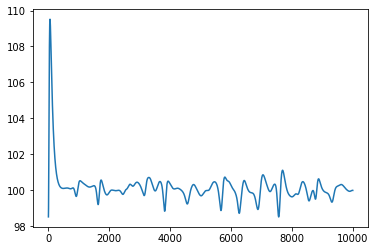

In [63]:
plt.plot(Tem)

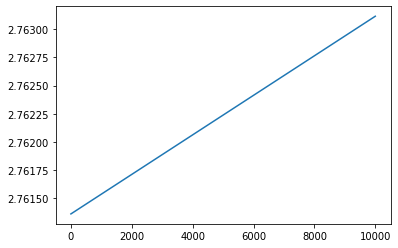

In [64]:
plt.plot(Pres)

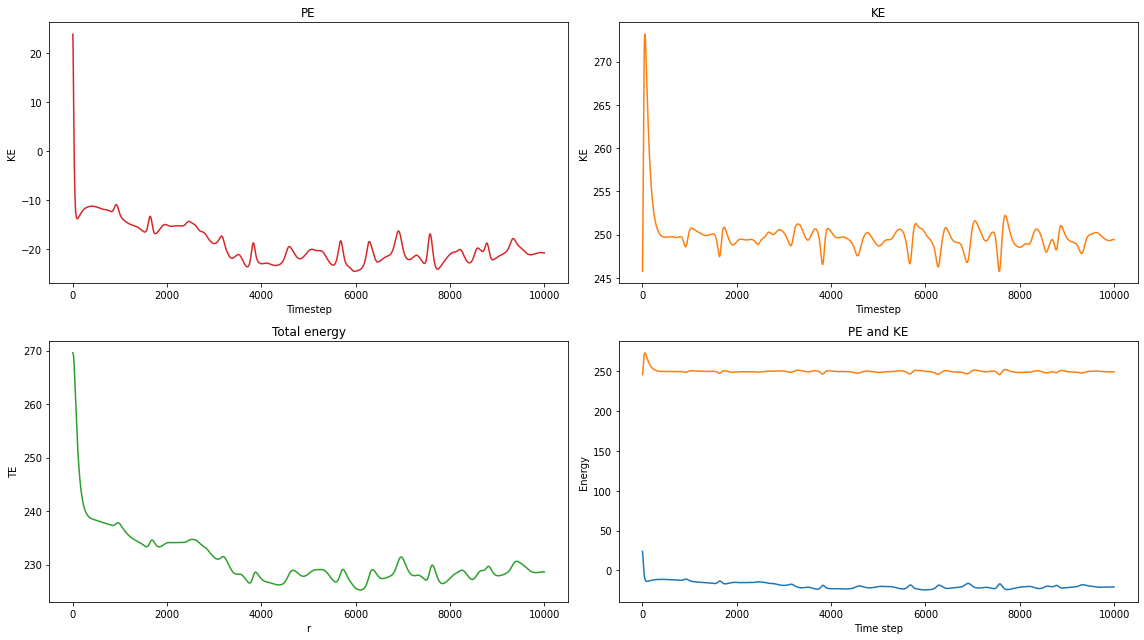

In [57]:
fig, axs = plt.subplots(2, 2, figsize=(16,9))

axs[0, 0].plot(PE, 'tab:red')
axs[0, 0].set_title('PE')
axs[0, 0].set_xlabel('Timestep')
axs[0, 0].set_ylabel('KE')

axs[0, 1].plot(KE, 'tab:orange')
axs[0, 1].set_title('KE')
axs[0, 1].set_xlabel('Timestep')
axs[0, 1].set_ylabel('KE')

axs[1, 0].plot(TE, 'tab:green') # spikes in the total energy at 10^-3 timestep 
axs[1, 0].set_title('Total energy')
axs[1, 0].set_xlabel('r')
axs[1, 0].set_ylabel('TE')

axs[1, 1].plot(PE,'tab:blue')
axs[1, 1].plot(KE, 'tab:orange')
axs[1, 1].set_title('PE and KE')
axs[1, 1].set_xlabel('Time step')
axs[1, 1].set_ylabel('Energy')

plt.tight_layout()